# Linear regression - Categorical data

<a target="_blank" href="https://colab.research.google.com/github/concordia-grad-computing-seminars/data-engineering/blob/main/ML/linear_regression/categorical_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Data

Data about wages in Canada compiled by the province of Ontario.

* [Source](https://open.canada.ca/data/en/dataset/1f14addd-e4fc-4a07-9982-ad98db07ef86)
* [Licence](https://www.ontario.ca/page/open-government-licence-ontario)

In [2]:
url = 'https://data.ontario.ca/dataset/1f14addd-e4fc-4a07-9982-ad98db07ef86/resource/7b325fa1-e9d6-4329-a501-08cdc22a79df/download/v0913_05.csv' 
raw_data = pd.read_csv(url)

### Cleaning

In [3]:
# Extract data of interest and simplify labels of columns
df = raw_data[(raw_data['Education level'] == 'Total, all education levels') &
              (raw_data['Age group'] == '15 years and over ') &
              (raw_data['Type of work'] == '   Full-time ') &
              (raw_data['Wages'] == 'Average hourly wage rate')].copy()

df.drop('Education level', axis=1, inplace=True)
df.drop('Age group', axis=1, inplace=True)
df.drop('Type of work', axis=1, inplace=True)
df.drop('Wages', axis=1, inplace=True)

df.rename(columns={'YEAR': 'Year',
                   'Both Sexes': 'Combined',
                   '  Male': 'Men',
                   '  Female': 'Women'}, inplace=True)

The data shows, for each province of Canada (and Canada itself), the average hourly salary for women, men and both combined.

In [4]:
df.head()

,Year,Geography,Combined,Men,Women
672,1997,Canada,16.54,17.83,14.79
2352,1997,Newfoundland and Labrador,13.88,15.16,12.24
4032,1997,Prince Edward Island,12.32,12.99,11.56
5712,1997,Nova Scotia,13.76,14.81,12.37
7392,1997,New Brunswick,13.63,14.77,12.08


To get an overview of the hourly salaries accross Canada, let us compute the average hourly wage (men and women combined) for each region and years in the data set, and sort them in decreasing order.

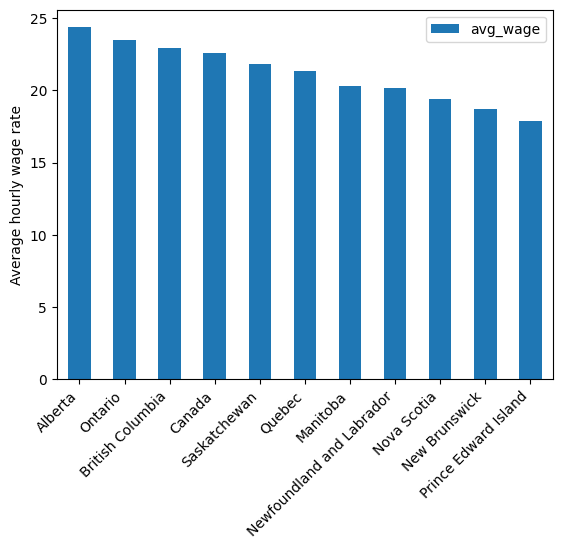

In [5]:
avg_wage = df.groupby('Geography')['Combined'].mean().reset_index(name='avg_wage')
avg_wage.sort_values('avg_wage', ascending=False).plot(x='Geography', y='avg_wage', kind='bar')

plt.xlabel('')
plt.ylabel('Average hourly wage rate')
plt.xticks(rotation=45, ha='right')
plt.show()

Our aim will be to develop linear models having as target values the average hourly salaries.

### Categorical data

The data contains one categorical field: the name of the provinces. If one aims to develop regression models having as target value the average hourly salary which take into account the province, two approaches can be followed.

1. Separate the data per province, and train the model for each province individually
2. Encode the categorical data by numbers

This second approach will be explored here.

A question that comes up is how to encode a categorical data into numbers. Three different approaches will be presented here and compared afterwards in using them for training a linear model.

#### Ordinal encoder

The simplest form of encoding is *ordinal encoding* as implemented by the [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) class in SciKit-Learn.

An ordinal encoder puts a unique integer to each categorical data. There is not particular rule as how to attribute this number, besides being unique.

An `OrdinalEncoder` has to be fitted to the categorical data one wants to encode. The input expected the the `fit` method has the same structure as for the `fit` methods used by `LinearRegression`.

In [6]:
enc = OrdinalEncoder()
enc.fit(np.c_[df['Geography']])

OrdinalEncoder()

The `OrdinalEncoder` detects itself the categories to be created based on the data provided in the `fit` method:

In [7]:
enc.categories_

[array(['Alberta', 'British Columbia', 'Canada', 'Manitoba',
        'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia',
        'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan'],
       dtype=object)]

Once fitted, any categorical data can be encoded with the `transform` method like this:

In [8]:
enc.transform([['Quebec']])

array([[9.]])

In [9]:
enc.transform([['Quebec'], 
               ['Ontario']])

array([[9.],
       [7.]])

As can be seen, there is no particular order in the numbering. We don't expect such an encoding will perform well in liner regression. Indeed, according this encoding Quebec and Ontario are relatively close to each others (only separated by 2 units). But if we go back to our graph displaying the average hourly salaries of the provinces in sorted way, we observe that in fact Ontario and Quebec are quite distant from each others.

We can display the encoding the `fit` method created for us:

In [10]:
for cat in enc.categories_[0]:
    print("{0:30} {1}".format(cat + ":", enc.transform([[cat]])))

Alberta:                       [[0.]]
British Columbia:              [[1.]]
Canada:                        [[2.]]
Manitoba:                      [[3.]]
New Brunswick:                 [[4.]]
Newfoundland and Labrador:     [[5.]]
Nova Scotia:                   [[6.]]
Ontario:                       [[7.]]
Prince Edward Island:          [[8.]]
Quebec:                        [[9.]]
Saskatchewan:                  [[10.]]


Indeed, the encoding that is attributed to the provinces is arbitrarily and is not correlated to the average hourly salary, our target value.

A better way would be not to encode arbitrarily the provinces but to encode them such that they follow the same order as do the average hourly salaries. This can be achieved by using the parameter `categories` in the constructor of the `OrdinalEncoder`. This parameter allows to pass a list of categories which one uses to encode later the data. The encoder will follow the order in which this list is passed.

In [11]:
# list of province sorted according the average hourly salary
cat = avg_wage.sort_values('avg_wage', ascending=False)['Geography'].to_list()

# Encoder using this sorted list
enc = OrdinalEncoder(categories=[cat])
enc.fit(np.c_[df['Geography']])

OrdinalEncoder(categories=[['Alberta', 'Ontario', 'British Columbia', 'Canada',
                            'Saskatchewan', 'Quebec', 'Manitoba',
                            'Newfoundland and Labrador', 'Nova Scotia',
                            'New Brunswick', 'Prince Edward Island']])

Once fitted, any categorical data can be encoded with the `transform` method like this:

In [12]:
enc.transform([['Quebec'], 
               ['Ontario']])

array([[5.],
       [1.]])

This time, Quebec and Ontario are significantly separated. Ontario as the index 1, as it is the province with the second highest average hourly salary.

The encoding is now indeed done according the average hours salary:

In [13]:
for cat in enc.categories_[0]:
    print("{0:30} {1}".format(cat + ":", enc.transform([[cat]])))

Alberta:                       [[0.]]
Ontario:                       [[1.]]
British Columbia:              [[2.]]
Canada:                        [[3.]]
Saskatchewan:                  [[4.]]
Quebec:                        [[5.]]
Manitoba:                      [[6.]]
Newfoundland and Labrador:     [[7.]]
Nova Scotia:                   [[8.]]
New Brunswick:                 [[9.]]
Prince Edward Island:          [[10.]]


#### One hot encoder

In *one hot encoding* additional features are created to encode the categorical data. The idea is to add features which values are 1 or 0 depending if the categorical data belongs or not to a given category. The class [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) allows to perform this type of encoding.

In [14]:
enc = OneHotEncoder()
enc.fit(np.c_[df['Geography']])

OneHotEncoder()

Once fitted, the `tranform` method can be applied to encode data. In order to ease visual reading, calling the `toarray` method is useful.

In [15]:
enc.transform([['Quebec']]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

As there are 10 provinces (and Canada), the `OneHotEncoder` has created 11 classes which are encoded with all 0 except one column containing a 1 to indicate to which province the data belongs.

To inspect which categories the `OneHotEncoder` has created, the `categories_` attribute can be used:

Checking all the encodings:

In [16]:
for cat in enc.categories_[0]:
    print("{0:30} {1}".format(cat + ":", enc.transform([[cat]]).toarray()))

Alberta:                       [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
British Columbia:              [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Canada:                        [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Manitoba:                      [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
New Brunswick:                 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Newfoundland and Labrador:     [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Nova Scotia:                   [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Ontario:                       [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Prince Edward Island:          [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Quebec:                        [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Saskatchewan:                  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Linear regression

We can now build our linear model aiming to predict the average hourly salary of women, using as features the calendar year and the geographical location of the worker. The features matrix becomes:

In [17]:
X = np.c_[df['Year'], df['Geography']]

And the target values

In [18]:
y = df.Women

To evaluated qualitatively our trained models, we will use the data from Quebec:

In [19]:
df_QC = df[df.Geography=='Quebec']
X_QC = np.c_[df_QC['Year'], df_QC['Geography']]
y_QC = df_QC.Women

To encode the geographical location of the worker we will use three approaches, as discussed above, and compare the results. To keep our codes clear we use pipelines to chain the encoding operations and the training.

### Ordinal encoding

As first approach we use *ordinal encoding* for the geographical location of the worker.

In [20]:
mod = make_pipeline(OrdinalEncoder(),
                    LinearRegression())
mod.fit(X, y)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('linearregression', LinearRegression())])

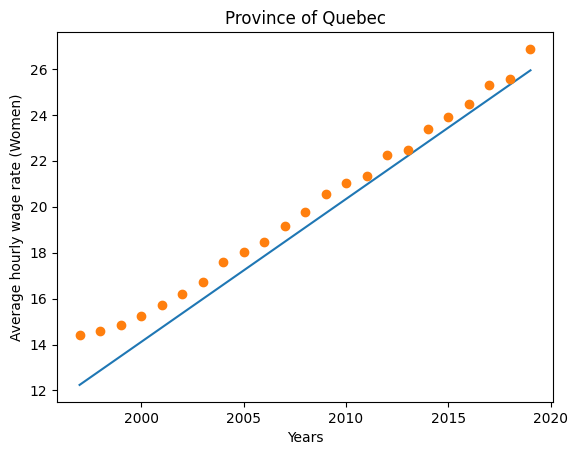

In [21]:
plt.plot(df_QC['Year'], mod.predict(X_QC), '-')
plt.plot(df_QC['Year'], y_QC, 'o')
plt.title('Province of Quebec')
plt.xlabel('Years')
plt.ylabel('Average hourly wage rate (Women)')
plt.show()

### Ordinal encoding on sorted data

In this second approach we want to include the sorting of the data according their average hourly salary. 

We start by sorting the provinces according their average hourly salary and then crate the needed categories to pass to the `OrdinalEncoder`.
Note that nothing special has to be done for the years, except to extract their unique values.

In [22]:
avg_wage = df.groupby('Geography')['Combined'].mean().reset_index(name='avg_wage')
cat = [df['Year'].unique(),
       avg_wage.sort_values('avg_wage', ascending=False)['Geography'].to_list()]

In [23]:
mod = make_pipeline(OrdinalEncoder(categories=cat),
                    LinearRegression())
mod.fit(X, y)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019]),
                                            ['Alberta', 'Ontario',
                                             'British Columbia', 'Canada',
                                             'Saskatchewan', 'Quebec',
                                             'Manitoba',
                                             'Newfoundland and Labrador',
                                             'Nova Scotia', 'New Brunswick',
                                             'Prince Edward Island']])),
                ('linearregression', LinearRegression())])

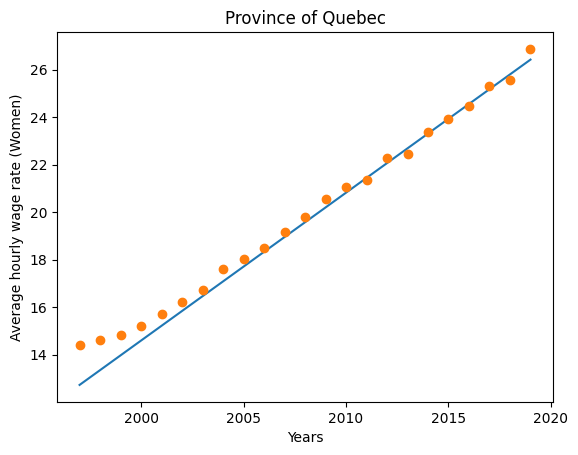

In [24]:
plt.plot(df_QC['Year'], mod.predict(X_QC), '-')
plt.plot(df_QC['Year'], y_QC, 'o')
plt.title('Province of Quebec')
plt.xlabel('Years')
plt.ylabel('Average hourly wage rate (Women)')
plt.show()

### One hot encoding

In [25]:
mod = make_pipeline(OneHotEncoder(),
                    LinearRegression())
mod.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('linearregression', LinearRegression())])

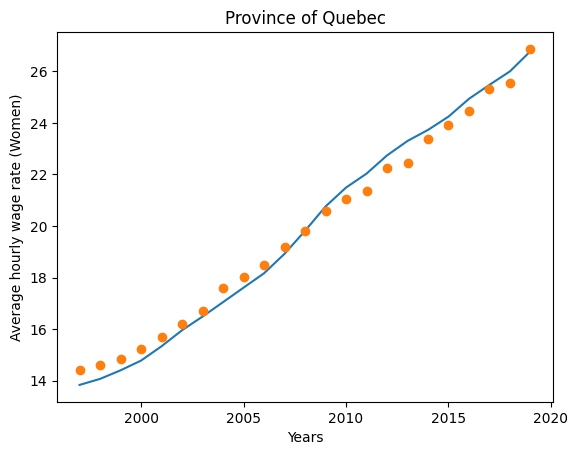

In [26]:
plt.plot(df_QC['Year'], mod.predict(X_QC), '-')
plt.plot(df_QC['Year'], y_QC, 'o')
plt.title('Province of Quebec')
plt.xlabel('Years')
plt.ylabel('Average hourly wage rate (Women)')
plt.show()

Note that with this approach we did hot encode all features, including the year. We can verify this by applying the fitted hot encoder to some input.

The various steps of the pipelines are accessible like this:

In [27]:
mod.steps

[('onehotencoder', OneHotEncoder()), ('linearregression', LinearRegression())]

This is a list of tuples where the first element is a name of the step (created for us by the `make_pipeline` function) and the transformer itself.

We are interested in the first step (the `OneHotEncoder`):

In [28]:
mod.steps[0][1]

OneHotEncoder()

Let us apply this first trasnsfomer to an element of our data set, for example `X[1]`:

In [29]:
X[1]

array([1997, 'Newfoundland and Labrador'], dtype=object)

If we transform this element, we observe that indeed all elements, including the year, was hot encoded:

In [30]:
mod.steps[0][1].transform([X[1]]).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.]])

### One hot encoding on some features only

If it is desired to hot encode only specific features within a pipeline, some more fine tuning of the pipeline is required. 

The pipeline must be built explicitly using the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) class. Prior being able to build the full `Pipeline`, we have to build two auxiliary pipelines, one for the features which do not require hot encoding and one for the features that require hot encoding.

The first `Pipeline` keeps the features as they are. We use for this a [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) where the function is the identity function (implemented here with a [`lambda`](https://www.w3schools.com/python/python_lambda.asp))

In [31]:
numeric_transformer = Pipeline(
    steps=[
        ("copy", FunctionTransformer(lambda X : X))
    ]
)

The second `Pipeline` applies the `OneHotEncoder`:

In [32]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)

Steps are defined as as a list of tuples of names (that can be freely chosen) and the classes of the operation the Pipeline will execute. In our example, we have ony a single step: the `OneHotEncoder`.

This `Pipeline` will have to be applied as very first step in the full pipeline on the second column (which is the `Geogrpahy` feature) of the features matrix `X`. This can be achieved with the help of a [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn-compose-columntransformer). We call this `ColumnTransformer` preprocessor, as it is a pre-processing step:

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [0]),
        ("cat", categorical_transformer, [1])
    ]
)

The `ColumnTransformer` requires a list of transformers in form of tuples with the format (name, transformer, columns). The name can be freely chosen. The transformer must be a pipeline and columns is a list of column numbers on which the transformer will be applied. In our case, the pipeline, `numeric_transformer`, applies to column number 0 and the pipeline, `categorical_transformer`, applies to column number 1.

We can now define the full `Pipeline` which chains our `preprocessor` and the `LinearRegression` model and fit it the usual way:

In [34]:
mod = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("regression", LinearRegression())]
    )

mod.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('copy',
                                                                   FunctionTransformer(func=<function <lambda> at 0x7fdae7476d40>))]),
                                                  [0]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  [1])])),
                ('regression', LinearRegression())])

Let us evaluate our fit on the particular case of the province Quebec:

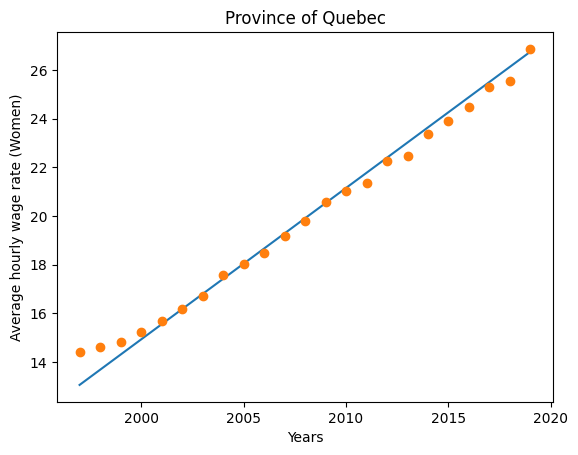

In [35]:
plt.plot(df_QC['Year'], mod.predict(X_QC), '-')
plt.plot(df_QC['Year'], y_QC, 'o')
plt.title('Province of Quebec')
plt.xlabel('Years')
plt.ylabel('Average hourly wage rate (Women)')
plt.show()

## Suggested activities

* Train models using as target value the hourly rate of men. Do you observe a difference between the salary paid to men and women?
* Evaluate your models for different provinces.
* Are there provinces which perform better in term of equity in salary than others?